In [1]:
import numpy as np
import copy 
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from matplotlib import animation, rc
rc('animation', html='jshtml')
from matplotlib import cm
from matplotlib import gridspec


In [2]:
### Running with least squares loss

class NeuralNet:
    def __init__(self, N_features=1, N_HL_neurons=5,N_epochs=100,batch_size = 32, learning_rate = 0.01): 

        self.params        = self.get_init_params(N_features,N_HL_neurons,1)
        self.cost_history  = None
        self.param_history = None
        self.N_epochs      = N_epochs 
        self.batch_size    = batch_size
        self.learning_rate = learning_rate

    def activation_func(self,X):
        """ Compute the activation function on every element of the input

            Args:
                x: np.array
            Returns:
                res: np.array same shape as x
        """
        # Gaussian wavelet 
        #res = np.multiply(X,np.exp(-np.power(X,2)))
        
        # Gaussian 
        #res = np.exp(-np.power(X,2))

        # Wavelet 
        #res = np.cos(5.0*X)*np.exp(-np.power(X,2))

        # Softmax 
        #res = np.exp(X)/(np.sum(np.exp(X)))

        # ReLU
        res = np.copy(X)
        res[X <= 0] = 0

        return res

    def activation_func_deriv(self, X):
        """ Compute the derivative of activation function on every element of the input

            Args:
                x: np.array
            Returns:
                res: np.array same shape as x
        """
        # Gaussian wavelet 
        #res = np.multiply(np.exp(-np.power(X,2)),1.0-2.0*np.power(X,2))

        # Gaussian 
        #res = -2.0*np.multiply(X,np.exp(-np.power(X,2)))
        
        # Wavelet 
        #res = -np.exp(-np.power(X,2))*(5.0*np.sin(5.0*X)+2.0*X*np.cos(5.0*X))

        # Softmax
        #res = -np.exp(X)/(1.0+np.exp(X))**2

        # ReLU
        res = np.ones(X.shape)
        res[X <= 0] = 0

        return res

    def make_dict(self,W1, b1, W2):
        """ Trivial helper function """
        return {'W1': W1, 'b1': b1, 'W2': W2}

    def get_init_params(self,input_dim, hidden_size, output_size):
        """ Initializer function using Xavier/he et al Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification

        Args:
        input_dim: int
        hidden_size: int
        output_size: int
        Returns:
        dict of randomly initialized parameter matrices.
        """
        W1 = np.random.normal(0, np.sqrt(2./(input_dim+hidden_size)), size=(input_dim, hidden_size))
        b1 = np.zeros((1, hidden_size))
        W2 = np.random.normal(0, np.sqrt(4./(hidden_size+output_size)), size=(hidden_size, output_size))

        return {'W1': W1, 'b1': b1, 'W2': W2}

    def predict(self, X, params):
            """ Compute class prediction for all data points in class X
            
            Args:
                X: np.array shape n, d
                params: dict of params to use (if none use stored params)
            Returns:
                np.array shape n, 1
            """
            n          = X.shape[0]
            prediction = np.zeros(n)

            # Computing forward pass #
            for i in range(n):
                a = X[i]*params['W1']
                b = a+params['b1']
                c = self.activation_func(b)
                d = c@params['W2']
                prediction[i] = d

            return prediction

    def score(self, X, y, params):
        """ Compute accuracy of model on data X with labels y
        
        Args:
            X: np.array shape n, d
            y: np.array shape n, 1
            params: dict of params to use (if none use stored params)

        Returns:
            np.array shape n, 1
        """
        acc, n     = 0, X.shape[0]
        prediciton = self.predict(X, params)

        for i in range(n):
            if prediciton[i] == y[i]:
                acc += 1
        acc *= 1.0/n
        
        return acc

    def cost_grad(self,X, y, params):
            """ Compute cost and gradient of neural net on data X with labels y using weight decay parameter c
            You should implement a forward pass and store the intermediate results 
            and the implement the backwards pass using the intermediate stored results
            
            Use the derivative for cost as a function for input to softmax as derived above
            
            Args:
                X: np.array shape n, self.input_size
                y: np.array shape n, 1
                params: dict with keys (W1, W2, b1, b2)
                c: float - weight decay parameter
                params: dict of params to use for the computation
            
            Returns 
                cost: scalar - average cross entropy cost
                dict with keys
                d_w1: np.array shape w1.shape, entry d_w1[i, j] = \partial cost/ \partial W1[i, j]
                d_w2: np.array shape w2.shape, entry d_w2[i, j] = \partial cost/ \partial W2[i, j]
                d_b1: np.array shape b1.shape, entry d_b1[1, j] = \partial cost/ \partial b1[1, j]
                
            """
            W1 = params['W1']
            b1 = params['b1']
            W2 = params['W2']

            cost, n    = 0.0, X.shape[0]
            deriv_dict = self.make_dict(np.zeros(W1.shape),np.zeros(b1.shape),np.zeros(W2.shape))

            for i in range(n):
                # Computing forward pass #
                a = X[i]*W1 
                b = a+b1 
                c = self.activation_func(b)
                d = c@W2
                e = d - y[i]
                f = np.power(e,2)
                cost += f

                # Computing backpropagation #
                d_W2 = (2.0*e*c).reshape(deriv_dict['W2'].shape[0],1)
                d_W1 = 2.0*e*self.activation_func_deriv(c)
                d_b1 = 2.0*e*c

                deriv_dict['W1'] += d_W1
                deriv_dict['b1'] += d_b1
                deriv_dict['W2'] += d_W2

            # Norming #
            cost             *= 1.0/n 
            deriv_dict['W1'] *= 1.0/n
            deriv_dict['W2'] *= 1.0/n
            deriv_dict['b1'] *= 1.0/n

            return cost, {'d_W1': deriv_dict['W1'], 'd_W2': deriv_dict['W2'], 'd_b1': deriv_dict['b1']}
        
    def fit(self, X_train, y_train, init_params):
            """ Run Mini-Batch Gradient Descent on data X, Y to minimize the in sample error for Neural Net classification
        
            Args:
            X_train: numpy array shape (n, d) - the training data each row is a data point
            y_train: numpy array shape (n,)   - training target labels 

            init_params: dict - has initial setting of parameters

            Sets: 
            params: dict with keys {W1, W2, b1,} parameters for neural net
            returns
            hist: dict:{keys: train_loss, train_acc, val_loss, val_acc} each an np.array of size epochs of the the given cost after every epoch
            loss is the NLL loss and acc is accuracy
            """
            
            params = init_params
            
            cost   = np.zeros(self.N_epochs)

            param_history = []

            param_history.append(copy.deepcopy(params))

            for i in range(self.N_epochs):
                X_perm = np.random.permutation(X_train)
                Y_perm = np.random.permutation(y_train)
                X_batch, Y_batch = X_perm[:self.batch_size], Y_perm[:self.batch_size]

                # Gradient run #
                for j in range(X_train.shape[0]//self.batch_size):
                    _, grad = self.cost_grad(X_batch,Y_batch,params)
                    params['W1'] -= self.learning_rate*grad['d_W1']
                    params['W2'] -= self.learning_rate*grad['d_W2']
                    params['b1'] -= self.learning_rate*grad['d_b1']

                # Calculating cost and score at current epoch #
                current_cost ,_ = self.cost_grad(X_train,y_train,params)

                # Appending value of cost function at current epoch #
                cost[i] = current_cost

                param_history.append(copy.deepcopy(params))

            self.param_history = param_history
            self.cost_history = {'train_cost': cost}
            self.params = {'W1': params['W1'], 'b1': params['b1'], 'W2': params['W2']}
          





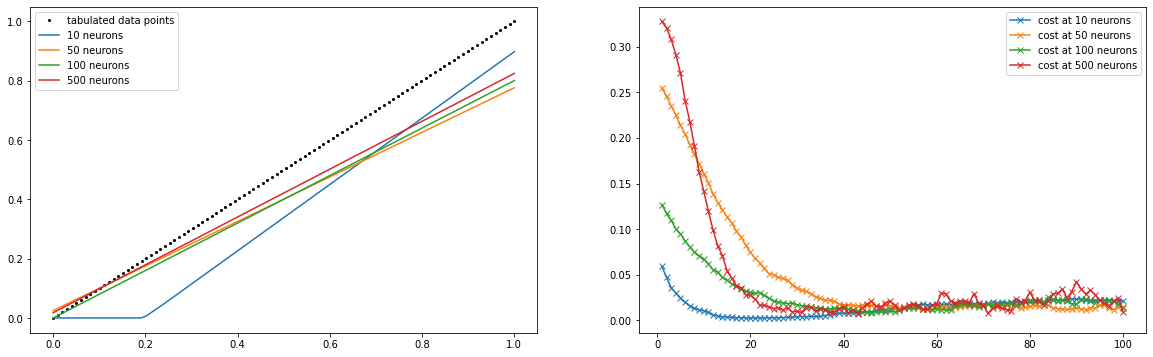

In [3]:
def func(x):
    return x#-x**2

xs = np.linspace(0.0,1.0,100)
ys = func(xs)


N_epoch = 100
lr = 0.005
batch_size = 32

n1 = 10
n2 = 50
n3 = 100
n4 = 500

test1 = NeuralNet(N_HL_neurons=n1,N_epochs=N_epoch,learning_rate=lr,batch_size=batch_size)
test1.fit(xs,ys,test1.params)
prediction1 = test1.predict(xs,test1.params)

test2 = NeuralNet(N_HL_neurons=n2,N_epochs=N_epoch,learning_rate=lr,batch_size=batch_size)
test2.fit(xs,ys,test2.params)
prediction2= test2.predict(xs,test2.params)

test3 = NeuralNet(N_HL_neurons=n3,N_epochs=N_epoch,learning_rate=lr,batch_size=batch_size)
test3.fit(xs,ys,test3.params)
prediction3 = test3.predict(xs,test3.params)

test4 = NeuralNet(N_HL_neurons=n4,N_epochs=N_epoch,learning_rate=lr,batch_size=batch_size)
test4.fit(xs,ys,test4.params)
prediction4 = test4.predict(xs,test4.params)

fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(xs,ys,'ko',ms=2,label='tabulated data points')

ax[0].plot(xs,prediction1,label=str(n1)+' neurons')
ax[0].plot(xs,prediction2,label=str(n2)+' neurons')
ax[0].plot(xs,prediction3,label=str(n3)+' neurons')
ax[0].plot(xs,prediction4,label=str(n4)+' neurons')

ax[1].plot(np.arange(1,len(test1.cost_history['train_cost'])+1,1),test1.cost_history['train_cost'],'-x',label='cost at '+str(n1)+' neurons')
ax[1].plot(np.arange(1,len(test2.cost_history['train_cost'])+1,1),test2.cost_history['train_cost'],'-x',label='cost at '+str(n2)+' neurons')
ax[1].plot(np.arange(1,len(test3.cost_history['train_cost'])+1,1),test3.cost_history['train_cost'],'-x',label='cost at '+str(n3)+' neurons')
ax[1].plot(np.arange(1,len(test4.cost_history['train_cost'])+1,1),test4.cost_history['train_cost'],'-x',label='cost at '+str(n4)+' neurons')

ax[0].legend()
ax[1].legend()



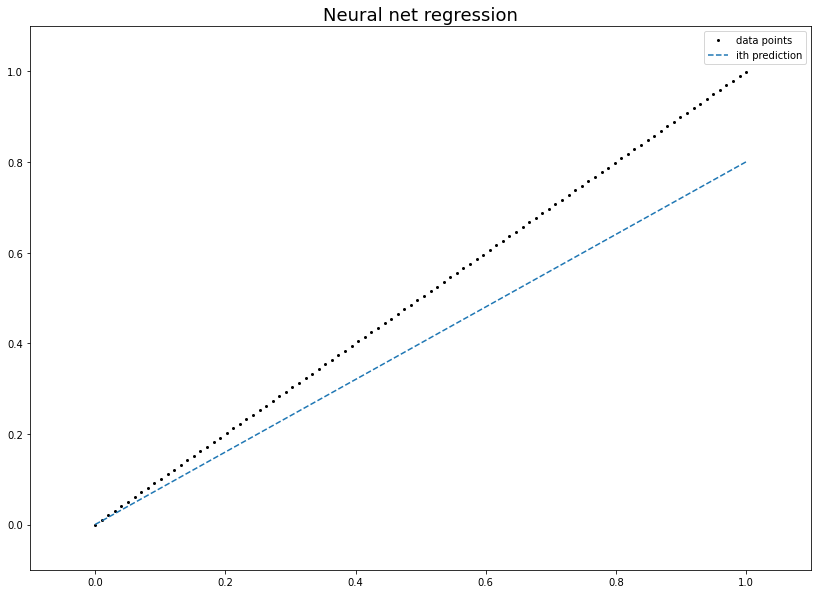

In [4]:
predictions = []
for i in range(len(test3.param_history)):
    predictions.append(test3.predict(xs,test3.param_history[i]))
    
## Defining plot ##
## Defining x- & y-limits for plot ##

fig, ax = plt.subplots(1,1,figsize = (14,10))
ax.set_title('Neural net regression',size=18)
ax.plot(xs,ys,'ko',label='data points',ms=2)

NN_predictions, = ax.plot([],[],'--',color='tab:blue',label='ith prediction')


def update(i):
    NN_predictions.set_data(xs,predictions[i])

    return NN_predictions,


ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.legend(loc='upper right')

anim = animation.FuncAnimation(fig,
                               update,
                               frames=len(predictions),
                               interval=70,
                               blit=True,
                               repeat_delay=0)
# Set up formatting for the movie files

## uncomment below to save gif ##
#writergif = animation.PillowWriter(fps=3) 
#anim.save("BinaryGA_2.gif", writer=writergif)

anim